In [42]:
import os, sys

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from nbafuns import *
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

data_DIR = "../data/rapm/"
misc_DIR = "../data/misc/"
model_path = "../data/models/"
pbp_DIR = "../data/pbpdata/"
fig_DIR = "../figs/analysis/"

team_dict, team_list  = get_teams()

In [43]:
# Generate sample in-game data (replace with your actual play-by-play data)
def load_ingame_data():
    # Simulating play-by-play data
    data = pd.read_parquet(data_DIR + "NBA_rapm_possessions_odds_2017_2024.parquet")
    return data

# Feature engineering
def engineer_features(df):
    # Add useful derived features
    df["spread_mod"] = df["spread"]*(df["secs"]/ 2880)**4
    df['time_remaining_pct'] = df['secs'] / 2880
    df['points_per_second'] = df['margin'] / (2880 - df['secs']).clip(lower=1)
    df['is_endgame'] = (df['secs'] < 300) & (df['period'] == 4).astype(int)
    
    features = [
        'margin',
        'secs',
        'spread_mod',
        'period',
        'homeball',
        # 'time_remaining_pct',
        # 'points_per_second',
        # 'spread_mod',
        'is_endgame',
    ]
    return df, features

def prepare_data(df, features):
    X = df[features]
    y = df['win']
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    return X_train, X_test, y_train, y_test

def train_catboost_model(X_train, X_test, y_train, y_test):
    # Define categorical features
    cat_features = ['period', 'homeball', 'is_endgame']
    
    # Create data pools
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    test_pool = Pool(X_test, y_test, cat_features=cat_features)
    
    # Initialize model
    model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=42,
        verbose=100,
        use_best_model=True,
        # task_type="GPU",
    )
    
    # Train model
    model.fit(
        train_pool,
        eval_set=test_pool,
        early_stopping_rounds=50
    )
    
    return model

def evaluate_model(model, X_test, y_test):
    # Predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    logloss = log_loss(y_test, y_pred_proba)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Log Loss: {logloss:.4f}")
    
    return y_pred_proba

In [44]:
# Load and process data
df = load_ingame_data()
df, features = engineer_features(df)
X_train, X_test, y_train, y_test = prepare_data(df, features)

# Train model
model = train_catboost_model(X_train, X_test, y_train, y_test)

# Evaluate
predictions = evaluate_model(model, X_test, y_test)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.get_feature_importance()
}).sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

0:	test: 0.6954619	best: 0.6954619 (0)	total: 1.43s	remaining: 11m 53s
100:	test: 0.7219689	best: 0.7219689 (100)	total: 2m 57s	remaining: 11m 41s
200:	test: 0.7249297	best: 0.7249297 (200)	total: 5m 21s	remaining: 7m 58s
300:	test: 0.7268248	best: 0.7268248 (300)	total: 7m 46s	remaining: 5m 8s
400:	test: 0.7281864	best: 0.7281864 (400)	total: 10m 9s	remaining: 2m 30s
499:	test: 0.7293396	best: 0.7293396 (499)	total: 12m 21s	remaining: 0us

bestTest = 0.7293396365
bestIteration = 499

Accuracy: 0.6715
Log Loss: 0.5995

Feature Importance:
      feature  importance
2  spread_mod   68.317251
1        secs   18.042136
0      margin   13.335026
5  is_endgame    0.235425
3      period    0.070162
4    homeball    0.000000


In [45]:
gameids = df.gid.unique()

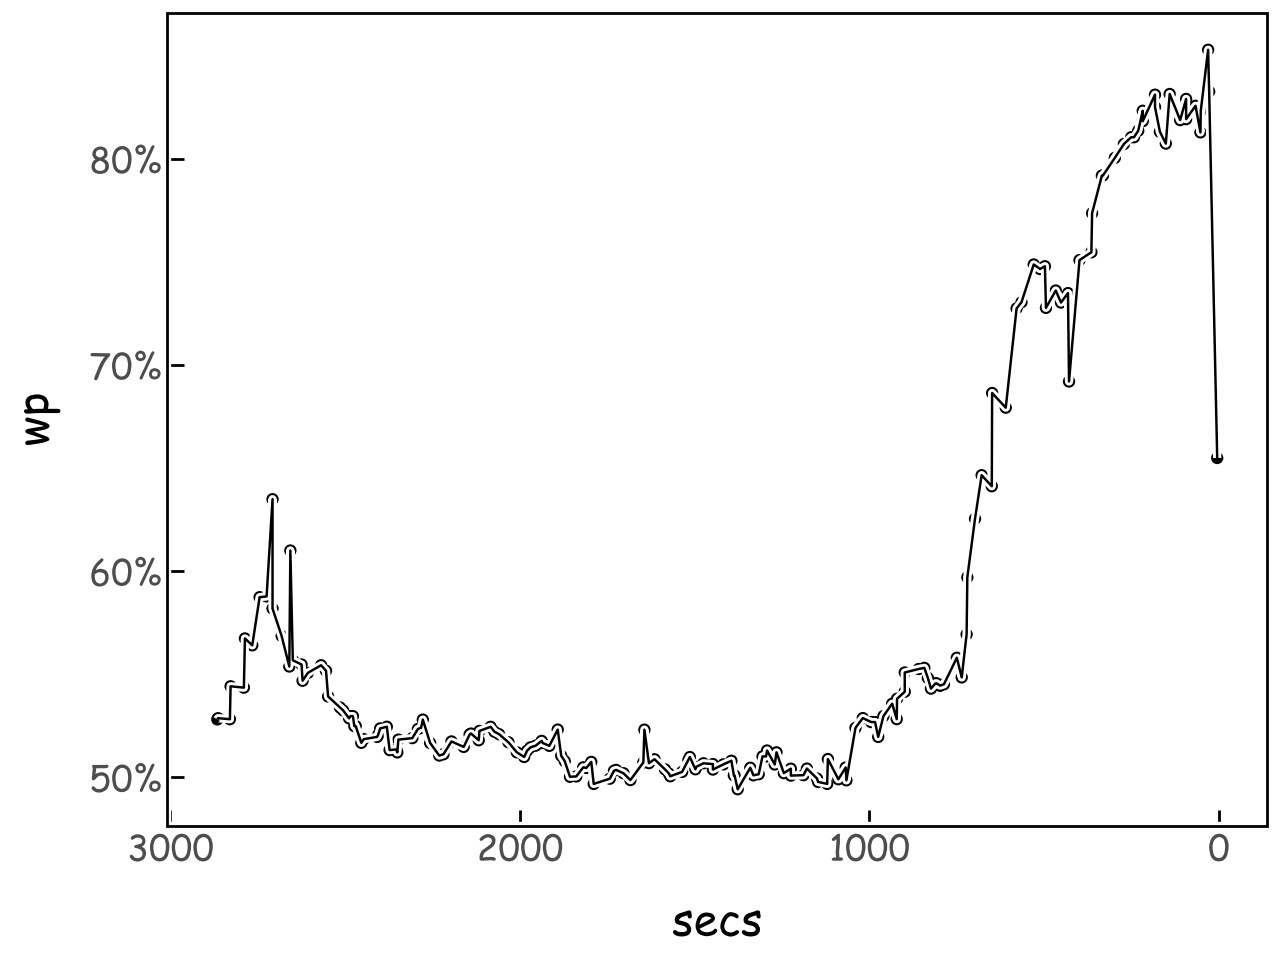

In [46]:
# i = 0
# gid = gameids[i]
gid = gameids[np.random.randint(0,len(gameids))]
dfp = df.query(f"gid == '{gid}'")
ypred = model.predict_proba(dfp[features])
dfp["wp"] = ypred[:,1]
p = (
    ggplot(dfp)
    + aes(x="secs",y="wp")
    + geom_point()
    + geom_line()
    + scale_y_continuous(labels=percent_format())
    + scale_x_reverse()
    + theme_idv
)
p